In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
data = pd.read_csv('AAPL_precos_abertura.csv')
data.head()

,Date,Open,Close
0,2019-01-02,38.722500,39.480000
1,2019-01-03,35.994999,35.547501
2,2019-01-04,36.132500,37.064999
3,2019-01-07,37.174999,36.982498
4,2019-01-08,37.389999,37.687500


In [15]:
data['Date'] = pd.to_datetime(data['Date'])
time_step = 40

Text(0.5, 0, 'Days')

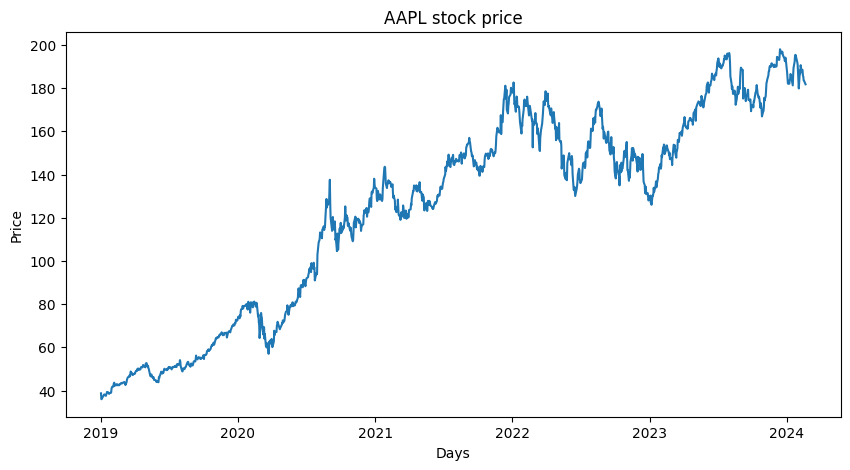

In [16]:
#plotting the data
plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['Open'])
plt.title('AAPL stock price')
plt.ylabel('Price')
plt.xlabel('Days')

In [17]:
split = int(len(data) * 0.75)
train = data[:split]
test = data[split:]
print("Train shape:",train.shape, "\nTest shape", test.shape)

Train shape: (969, 3) 
Test shape (323, 3)


## Creating X and Y train

In [18]:
X = train['Open'].values
X = X.reshape(-1, 1)
print(X.shape)

(969, 1)


In [19]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [20]:
X_train = []
y_train = []

for i in range(time_step, len(train)):
    X_train.append(X[i-time_step:i, 0])
    y_train.append(X[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
print("X_train shape:", X_train.shape, "\ny_train shape:", y_train.shape)

X_train shape: (929, 40) 
y_train shape: (929,)


In [21]:
#Reshape the data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train shape:", X_train.shape)
y_train = y_train.reshape(-1, 1)
print("y_train shape:", y_train.shape)

X_train shape: (929, 40, 1)
y_train shape: (929, 1)


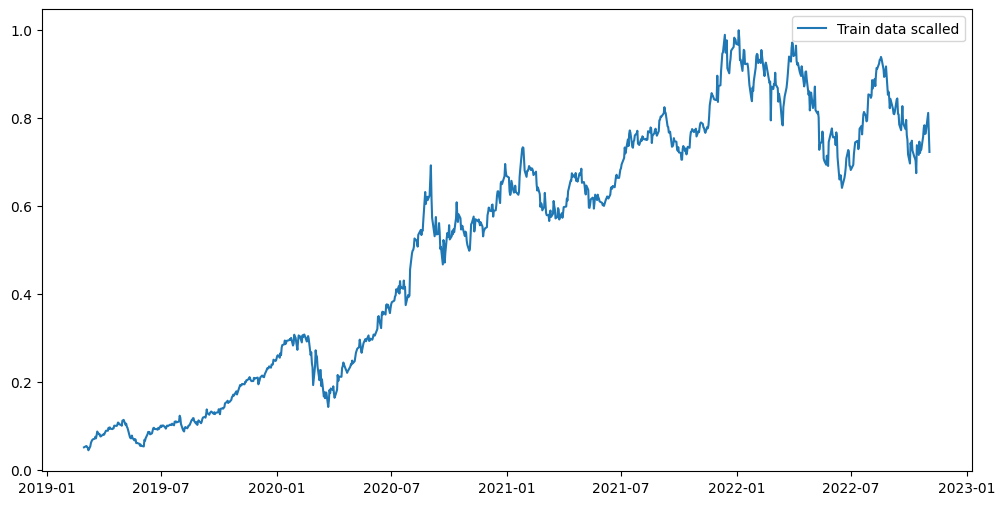

In [22]:
#plotting the data
plt.figure(figsize=(12,6))
plt.plot(train['Date'][time_step:], y_train, label='Train data scalled')
plt.legend()


## Creating X and Y test

In [23]:
test_data = scaler.transform(test['Open'].values.reshape(-1, 1))
print("Test data shape:", test_data.shape)

Test data shape: (323, 1)


In [24]:
X_test = []
y_test = []

for i in range(time_step, len(test)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
print("X_test shape:", X_test.shape, "\ny_test shape:", y_test.shape)

X_test shape: (283, 40) 
y_test shape: (283,)


In [25]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print("X_test shape:", X_test.shape)
y_test = y_test.reshape(-1, 1)
print("y_test shape:", y_test.shape)

X_test shape: (283, 40, 1)
y_test shape: (283, 1)


## Create LSTM model

In [26]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

2024-02-23 08:57:07.708053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 08:57:08.019240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 08:57:08.019317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 08:57:08.070989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 08:57:08.181823: I tensorflow/core/platform/cpu_feature_guar

In [27]:
# model
def create_ltsm_model(X, time_step):
    model = Sequential()
    model.add(LSTM(units=128,return_sequences=False, input_shape=(time_step, X.shape[2])))
    model.add(Dropout(0.3))
    model.add(Dense(units=30))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error',metrics = ["accuracy"])
    return model


In [28]:
model = create_ltsm_model(X_train, time_step)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 70461 (275.24 KB)
Trainable params: 70461 (275.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
30/30 [==============================] - 2s 13ms/step - loss: 0.0456 - accuracy: 0.0011
Epoch 2/10
30/30 [==============================] - 0s 12ms/step - loss: 0.0045 - accuracy: 0.0011
Epoch 3/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.0011
Epoch 4/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0030 - accuracy: 0.0011
Epoch 5/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.0011
Epoch 6/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.0011
Epoch 7/10
30/30 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 0.0011
Epoch 8/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0026 - accuracy: 0.0011
Epoch 9/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.0011
Epoch 10/10
30/30 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 0.0011


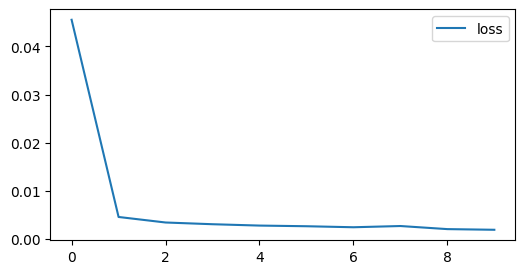

In [30]:
# Loss history
plt.figure(figsize=(6,3))
plt.plot(hist.history['loss'], label='loss')
plt.legend()


## Predict test

9/9 [==============================] - 0s 5ms/step


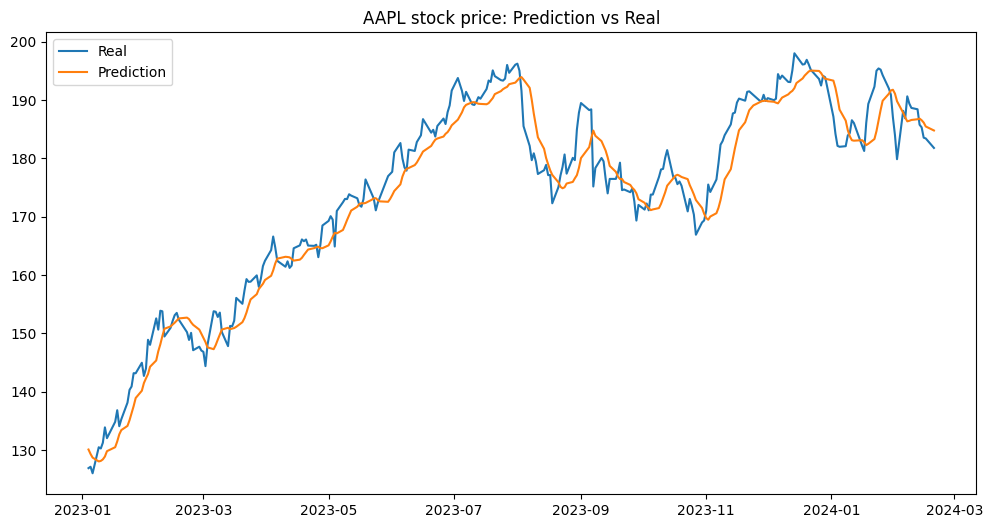

In [31]:
predict = model.predict(X_test)

#plotting the data
plt.figure(figsize=(12,6))
plt.plot(test['Date'][time_step:], scaler.inverse_transform(y_test), label='Real')
plt.plot(test['Date'][time_step:], scaler.inverse_transform(predict), label='Prediction')
plt.title('AAPL stock price: Prediction vs Real')
plt.legend()


## Predict Next 10 days

In [37]:
last = data.iloc[-time_step:]
last = last['Open'].values
last = scaler.transform(last.reshape(-1, 1))
print(last.shape)

(40, 1)


In [41]:
result = model.predict(last.reshape(1, time_step, 1))
result = scaler.inverse_transform(result)
print("Predicted price for the next day:", result)

1/1 [==============================] - 0s 18ms/step
Predicted price for the next day: [[183.91498]]


In [45]:
#predicting the next 10 days
days = 10
last = data.iloc[-time_step:]
last = last['Open'].values
last = scaler.transform(last.reshape(-1, 1))
appended = []

for i in range(days):
    result = model.predict(last.reshape(1, time_step, 1))
    #print(f"Predicted price for the next {i+1} day:", scaler.inverse_transform(result))
    last = np.append(last, result)
    last = last[1:]
    last = last.reshape(-1, 1)
    appended.append(scaler.inverse_transform(result))

for i in range(len(appended)):
    print(f"Predicted price for the next {i+1} day:", appended[i])

1/1 [==============================] - 0s 16ms/step
Predicted price for the next 1 day: [[183.91498]]
Predicted price for the next 2 day: [[183.41989]]
Predicted price for the next 3 day: [[182.9989]]
Predicted price for the next 4 day: [[182.62967]]
Predicted price for the next 5 day: [[182.29471]]
Predicted price for the next 6 day: [[181.98323]]
Predicted price for the next 7 day: [[181.6883]]
Predicted price for the next 8 day: [[181.40562]]
Predicted price for the next 9 day: [[181.13216]]
Predicted price for the next 10 day: [[180.86597]]
